<a href="https://colab.research.google.com/github/Zac-dev618/Job-Tech-IA-2025/blob/main/Job_Tech_IA_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
###  1. IMPORTATIONS DES BIBLIOTHEQUES ET CHARGEMENT Du DATASET   ###


import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.express as px
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.options.display.max_columns = None

df = pd.read_csv("/content/ai_job_dataset1.csv")

print(df.shape)
df.head()

(15000, 20)


,job_id,job_title,salary_usd,salary_currency,salary_local,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,Data Scientist,219728,USD,219728,EX,PT,Sweden,M,Sweden,0,"Python, Computer Vision, R, Docker",Associate,13,Transportation,2024-09-23,2024-10-31,1132,6.6,TechCorp Inc
1,AI00002,Head of AI,230237,JPY,25326070,EX,PT,Japan,L,Japan,50,"Kubernetes, MLOps, Tableau, Python",Bachelor,10,Transportation,2024-07-26,2024-09-12,2299,8.5,Cloud AI Solutions
2,AI00003,Data Engineer,128890,EUR,109557,EX,CT,Germany,S,Germany,100,"Spark, Scala, Hadoop, PyTorch, GCP",Bachelor,12,Automotive,2025-01-19,2025-03-28,1329,5.5,Quantum Computing Inc
3,AI00004,Computer Vision Engineer,96349,USD,96349,MI,FL,Finland,L,Finland,50,"MLOps, Linux, Tableau, Python",PhD,2,Automotive,2024-07-20,2024-09-06,1132,6.8,Cognitive Computing
4,AI00005,Robotics Engineer,63065,EUR,53605,EN,FT,France,S,France,100,"R, Scala, SQL, GCP, Python",Associate,0,Finance,2025-03-16,2025-05-09,2011,9.3,Advanced Robotics


In [ ]:
###  2. APERCU DES DONNEES   ###

df.describe(include='all')

print("\nPremières lignes du DataFrame df_processed (toutes les colonnes affichées) :")
print(df.head())


Premières lignes du DataFrame df_processed (toutes les colonnes affichées) :
    job_id                 job_title  salary_usd salary_currency  \
0  AI00001            Data Scientist      219728             USD   
1  AI00002                Head of AI      230237             JPY   
2  AI00003             Data Engineer      128890             EUR   
3  AI00004  Computer Vision Engineer       96349             USD   
4  AI00005         Robotics Engineer       63065             EUR   

   salary_local experience_level employment_type company_location  \
0        219728               EX              PT           Sweden   
1      25326070               EX              PT            Japan   
2        109557               EX              CT          Germany   
3         96349               MI              FL          Finland   
4         53605               EN              FT           France   

  company_size employee_residence  remote_ratio  \
0            M             Sweden             0

In [ ]:
### 3.  NETTOYAGE DES DONNEES ET PRETRAITEMENT   ###

# Copie de travail
df_clean = df.copy()


if 'job_id' in df_clean.columns:
    n_before = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=['job_id'])
    print(f"Déduplication par job_id : {n_before - len(df_clean)} doublon(s) retiré(s).")


df_clean['salary_usd'] = pd.to_numeric(df_clean.get('salary_usd'), errors='coerce')


essentielles = [c for c in ['salary_usd', 'experience_level', 'employment_type'] if c in df_clean.columns]
df_clean = df_clean.dropna(subset=essentielles)
df_clean = df_clean[df_clean['salary_usd'] > 0]


if 'experience_level' in df_clean.columns:
    exp_map = {
        'EN':'Entry-level','Entry':'Entry-level','Junior':'Entry-level','Entry-level':'Entry-level',
        'MI':'Mid-level','Mid':'Mid-level','Mid-level':'Mid-level',
        'SE':'Senior-level','Senior':'Senior-level','Senior-level':'Senior-level',
        'EX':'Executive-level','Expert':'Executive-level','Executive-level':'Executive-level'
    }
    df_clean['experience_level'] = df_clean['experience_level'].replace(exp_map).str.strip()

if 'employment_type' in df_clean.columns:
    emp_map = {
        'FT':'Full-time','PT':'Part-time','CT':'Contract','FL':'Freelance',
        'Full-time':'Full-time','Part-time':'Part-time','Contract':'Contract','Freelance':'Freelance'
    }
    df_clean['employment_type'] = df_clean['employment_type'].replace(emp_map).str.strip()


if 'remote_ratio' in df_clean.columns:
    rr = pd.to_numeric(df_clean['remote_ratio'], errors='coerce')

    remote_status = pd.Series(index=df_clean.index, dtype='object')
    remote_status[rr == 100] = 'Full Remote'
    remote_status[rr == 50]  = 'Partial Remote'
    remote_status[rr == 0]   = 'On-site'
    df_clean['remote_status'] = remote_status


for c in ['posting_date', 'application_deadline']:
    if c in df_clean.columns:
        df_clean[c] = pd.to_datetime(df_clean[c], errors='coerce')


if 'required_skills' in df_clean.columns:
    df_clean['required_skills'] = df_clean['required_skills'].fillna('')

print(f"Base prête pour l'analyse : {df_clean.shape}")
df_clean.head(3)

Déduplication par job_id : 0 doublon(s) retiré(s).
Base prête pour l'analyse : (15000, 21)


,job_id,job_title,salary_usd,salary_currency,salary_local,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name,remote_status
0,AI00001,Data Scientist,219728,USD,219728,Executive-level,Part-time,Sweden,M,Sweden,0,"Python, Computer Vision, R, Docker",Associate,13,Transportation,2024-09-23,2024-10-31,1132,6.6,TechCorp Inc,On-site
1,AI00002,Head of AI,230237,JPY,25326070,Executive-level,Part-time,Japan,L,Japan,50,"Kubernetes, MLOps, Tableau, Python",Bachelor,10,Transportation,2024-07-26,2024-09-12,2299,8.5,Cloud AI Solutions,Partial Remote
2,AI00003,Data Engineer,128890,EUR,109557,Executive-level,Contract,Germany,S,Germany,100,"Spark, Scala, Hadoop, PyTorch, GCP",Bachelor,12,Automotive,2025-01-19,2025-03-28,1329,5.5,Quantum Computing Inc,Full Remote


In [ ]:
###  4.  VERIFICATION DES VALEURS MANQUANTES    ###


def report_missing(df: pd.DataFrame, name: str = "DataFrame"):
    print(f"\n--- Valeurs manquantes dans {name} ---")
    n = len(df)
    miss_count = df.isna().sum()
    miss_count = miss_count[miss_count > 0].sort_values(ascending=False)

    if miss_count.empty:
        print("Aucune valeur manquante trouvée.")
        return

    miss_pct = (miss_count / n * 100).round(2)
    report = pd.DataFrame({"manquants": miss_count, "%": miss_pct})
    print(report)


report_missing(df, "df (brut)")
report_missing(df_clean, "df_clean (après nettoyage)")




--- Valeurs manquantes dans df (brut) ---
Aucune valeur manquante trouvée.

--- Valeurs manquantes dans df_clean (après nettoyage) ---
Aucune valeur manquante trouvée.


In [ ]:
###  4.2.   Total Pays représentés     ###

d = (df_clean if 'df_clean' in globals() else df).copy()

# Pays propres
d = d.dropna(subset=['company_location'])
d['company_location'] = d['company_location'].astype(str).str.strip()
d['company_location'] = d['company_location'].replace({
    'USA': 'United States',
    'United States of America': 'United States',
    'UK': 'United Kingdom'
})


if 'job_id' in d.columns:
    d = d.drop_duplicates(subset=['job_id'])

#  Total de pays représentés
n_pays_total = d['company_location'].nunique()
print(f"Pays représentés (tous) : {n_pays_total}")

#  Pays avec au moins 1 offre
n_pays_50plus = (d.groupby('company_location').size() >= 50).sum()
print(f"Pays avec ≥ 1 offres : {n_pays_50plus}")

Pays représentés (tous) : 20
Pays avec ≥ 1 offres : 20


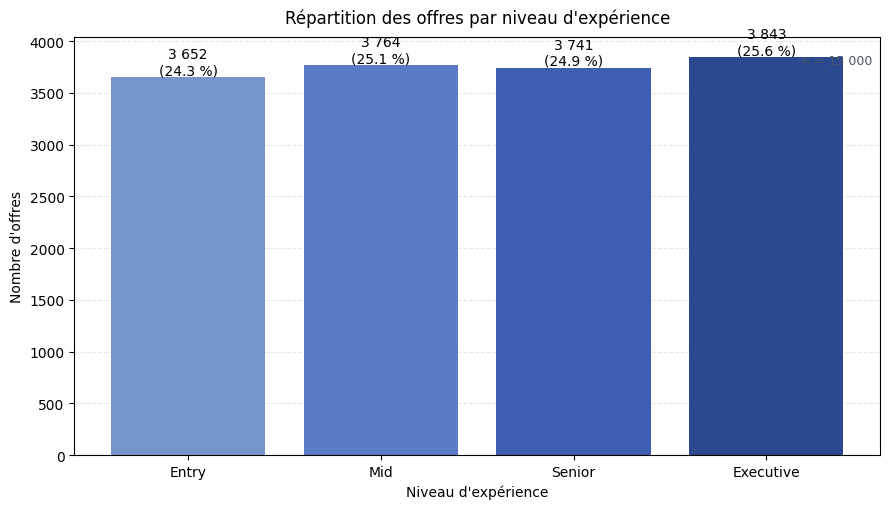

Répartition par niveau d'expérience :
                 offres
niveau                 
Entry-level        3652
Mid-level          3764
Senior-level       3741
Executive-level    3843


In [ ]:
###    5. ANALYSE ET VISUALISATION DES NIVEAUX D’EXPÉRIENCE ET D’EMPLOI    ###


df_src = None
for name in ['df_clean', 'df_processed']:
    if name in globals():
        df_src = globals()[name]
        break
if df_src is None:
    raise ValueError("Aucun DataFrame disponible.")


order_exp = ['Entry-level', 'Mid-level', 'Senior-level', 'Executive-level']
counts = (df_src['experience_level']
          .value_counts()
          .reindex(order_exp, fill_value=0))
total = int(counts.sum())


labels_fr = ['Entry', 'Mid', 'Senior', 'Executive']
colors = ['#7895CB', '#5A7BC6', '#3E5FB1', '#2B4891']

fig, ax = plt.subplots(figsize=(9, 5.2))
bars = ax.bar(labels_fr, counts.values, color=colors)

#  Annotations (valeur + %)
for rect, val in zip(bars, counts.values):
    pct = (val / total * 100) if total > 0 else 0
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
            f"{val:,}\n({pct:.1f} %)".replace(",", " "),
            ha='center', va='bottom', fontsize=10)


ax.set_title("Répartition des offres par niveau d'expérience", pad=10)
ax.set_xlabel("Niveau d'expérience")
ax.set_ylabel("Nombre d'offres")
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)


ax.text(0.99, 0.96, f"n = {total:,}".replace(",", " "),
        transform=ax.transAxes, ha='right', va='top', fontsize=9, color='#4A5568')

plt.tight_layout()
plt.show()


print("Répartition par niveau d'expérience :")
print(counts.rename_axis("niveau").to_frame("offres"))

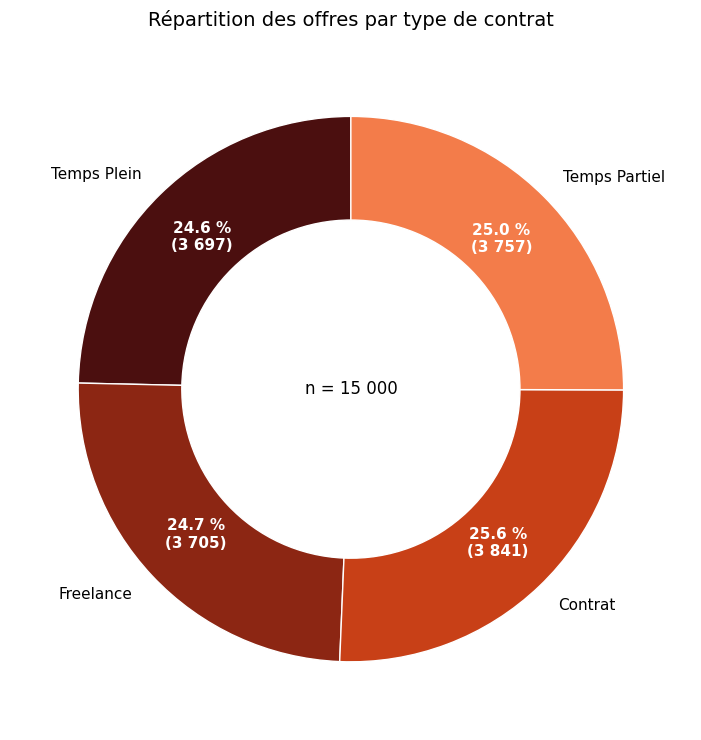

In [ ]:
###  5.2 DONUT GRAPH ###


df_src = None
for name in ['df_clean', 'df_processed']:
    if name in globals():
        df_src = globals()[name].copy()
        break
if df_src is None:
    raise ValueError("Aucun DataFrame disponible")


if 'employment_type' not in df_src.columns:
    raise ValueError("Colonne 'employment_type' absente du DataFrame.")


employment_mapping = {'FT': 'Full-time', 'PT': 'Part-time', 'CT': 'Contract', 'FL': 'Freelance'}
df_src['employment_type'] = df_src['employment_type'].replace(employment_mapping).astype(str).str.strip()


if 'job_id' in df_src.columns:
    df_src = df_src.drop_duplicates(subset=['job_id'])


order_en  = ['Full-time', 'Freelance', 'Contract', 'Part-time']
labels_fr = ['Temps Plein', 'Freelance', 'Contrat', 'Temps Partiel']

counts = (df_src['employment_type']
          .value_counts()
          .reindex(order_en, fill_value=0))
total = int(counts.sum())


colors = ['#4B0F0F', '#8C2613', '#C84017', '#F37C4A']

def fmt_int_fr(x: int) -> str:
    return f"{x:,}".replace(",", " ")

def autopct_fmt(pct):
    n = int(round(pct / 100.0 * total))
    return f"{pct:0.1f} %\n({fmt_int_fr(n)})"

# 5) Tracé
fig, ax = plt.subplots(figsize=(7.5, 7.5))
wedges, texts, autotexts = ax.pie(
    counts.values,
    labels=labels_fr,
    colors=colors,
    startangle=90,
    autopct=autopct_fmt,
    pctdistance=0.78,
    textprops={'fontsize': 11},
    wedgeprops=dict(width=0.38, edgecolor='white')
)

# Valeurs internes en blanc (lisibilité)
for t in autotexts:
    t.set_color('white')
    t.set_weight('bold')

# Titre + compteur central
ax.set_title("Répartition des offres par type de contrat", pad=16, fontsize=14)
ax.text(0, 0, f"n = {fmt_int_fr(total)}", ha='center', va='center', fontsize=12)

ax.set_aspect('equal')
plt.tight_layout()
plt.show()


Statistiques descriptives pour les salaires en USD :
count    15 000.00
mean    121 991.94
std      63 968.36
min      16 621.00
25%      74 978.50
50%     107 261.50
75%     155 752.25
max     410 273.00


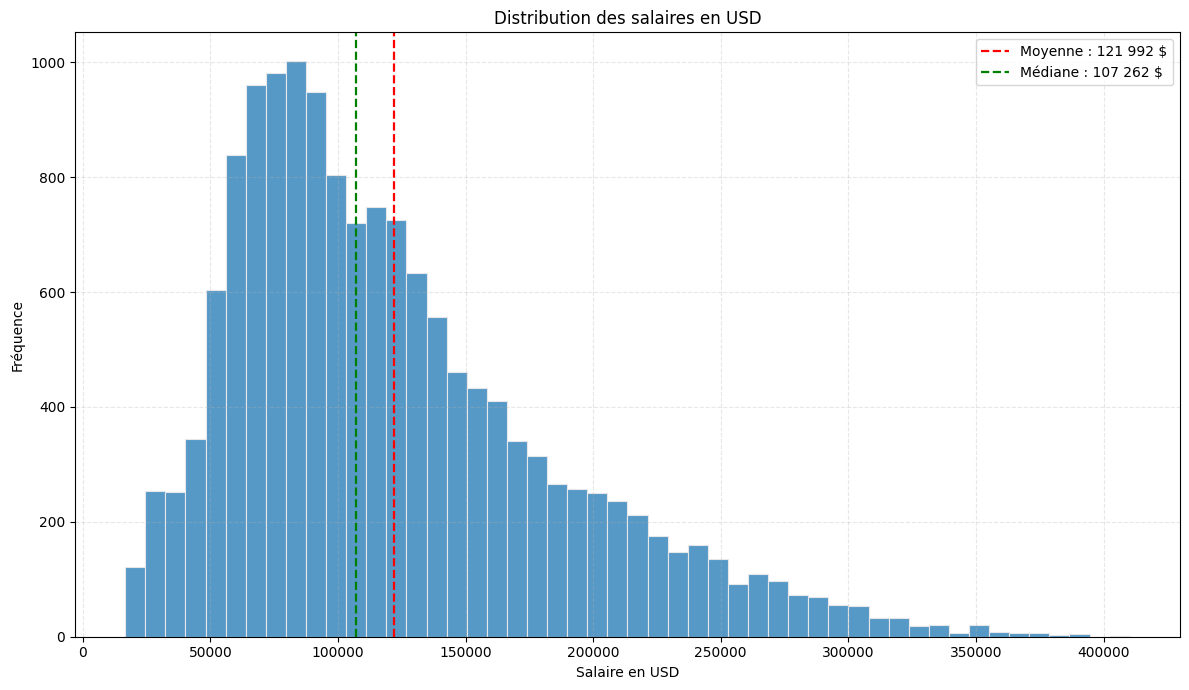

In [ ]:
###  6.1  ANALYSE DES SALAIRES / histogramme  ###


if 'df_clean' not in globals():
    raise ValueError("df_clean est introuvable.")

s = pd.to_numeric(df_clean['salary_usd'], errors='coerce')
s = s.dropna()
s = s[s > 0]

stats = s.describe()
print("Statistiques descriptives pour les salaires en USD :")
print(stats.to_string(float_format=lambda x: f"{x:,.2f}".replace(",", " ")))

mean_val, median_val = stats['mean'], stats['50%']

plt.figure(figsize=(12, 7))
sns.histplot(s, bins=50, kde=False, stat="count", element="bars", linewidth=0.8, edgecolor="#e5e7eb")
plt.title('Distribution des salaires en USD')
plt.xlabel('Salaire en USD')
plt.ylabel('Fréquence')
plt.axvline(mean_val,   color='red',   linestyle='--', linewidth=1.6, label=f"Moyenne : {mean_val:,.0f} $".replace(",", " "))
plt.axvline(median_val, color='green', linestyle='--', linewidth=1.6, label=f"Médiane : {median_val:,.0f} $".replace(",", " "))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:
###  6.2   MOYENNE JUNIOR VS SENIOR (Executive-level)   ###

base = df_clean.copy()

# Normalisation niveaux (sécurité)
exp_map = {
    'EN':'Entry-level','Entry':'Entry-level','Junior':'Entry-level','Entry-level':'Entry-level',
    'MI':'Mid-level','Mid':'Mid-level','Mid-level':'Mid-level',
    'SE':'Senior-level','Senior':'Senior-level','Senior-level':'Senior-level',
    'EX':'Executive-level','Expert':'Executive-level','Executive-level':'Executive-level'
}
base['experience_level'] = base['experience_level'].replace(exp_map).astype(str).str.strip()
base['salary_usd'] = pd.to_numeric(base['salary_usd'], errors='coerce')

clean = base.dropna(subset=['salary_usd','experience_level'])
clean = clean[clean['salary_usd'] > 0]

# Moyennes par niveau
means = clean.groupby('experience_level')['salary_usd'].mean().round(2)
counts = clean['experience_level'].value_counts()

print("Moyenne (USD) par niveau :\n", means)
print("\nEffectifs par niveau :\n", counts)

def compare(a, b):
    if a not in means.index or b not in means.index:
        print(f"\nComparaison {a} vs {b} impossible (niveau manquant).")
        return
    m_a, m_b = means[a], means[b]
    diff_abs = m_b - m_a
    diff_pct = (diff_abs / m_a * 100) if m_a > 0 else np.nan
    print(f"\n{a} → {b} :")
    print(f"  {a} = {m_a:,.0f} $ | {b} = {m_b:,.0f} $".replace(",", " "))
    print(f"  Écart absolu = {diff_abs:,.0f} $ ; Écart relatif = {diff_pct:.1f} %".replace(",", " "))

# Comparaisons clés
compare('Entry-level','Senior-level')      # ce que tu as déjà fait
compare('Entry-level','Executive-level')   # extrêmes (bas vs plus haut)
compare('Mid-level','Senior-level')        # utile aussi


Moyenne (USD) par niveau :
 experience_level
Entry-level         66773.74
Executive-level    198485.21
Mid-level           91585.49
Senior-level       127910.97
Name: salary_usd, dtype: float64

Effectifs par niveau :
 experience_level
Executive-level    3843
Mid-level          3764
Senior-level       3741
Entry-level        3652
Name: count, dtype: int64

Entry-level → Senior-level :
  Entry-level = 66 774 $ | Senior-level = 127 911 $
  Écart absolu = 61 137 $ ; Écart relatif = 91.6 %

Entry-level → Executive-level :
  Entry-level = 66 774 $ | Executive-level = 198 485 $
  Écart absolu = 131 711 $ ; Écart relatif = 197.3 %

Mid-level → Senior-level :
  Mid-level = 91 585 $ | Senior-level = 127 911 $
  Écart absolu = 36 325 $ ; Écart relatif = 39.7 %


In [ ]:
###   6.3   VALEUR AUGMENTATAION MOYENNE SALARIALE POUR UNE ANNEE DE PLUS (EXPERIENCE)  ###

if 'df_clean' not in globals():
    raise ValueError("df_clean est introuvable.")
tmp = df_clean.copy()


x = pd.to_numeric(tmp.get('years_experience'), errors='coerce')   # années d'expérience
y = pd.to_numeric(tmp.get('salary_usd'),       errors='coerce')   # salaire USD

mask = x.notna() & y.notna() & (x >= 0) & (y > 0)
data = pd.DataFrame({'years': x[mask], 'salary': y[mask]})


# Régression linéaire simple: salary ≈ a * years + b
a, b = np.polyfit(data['years'], data['salary'], 1)  # a = pente ($/an), b = intercept


y_pred = a * data['years'] + b
ss_res = ((data['salary'] - y_pred) ** 2).sum()
ss_tot = ((data['salary'] - data['salary'].mean()) ** 2).sum()
r2 = 1 - ss_res / ss_tot


fmt_money = lambda v: f"{v:,.2f} $".replace(",", " ")
print(f"Augmentation moyenne estimée par année d'expérience : {fmt_money(a)}")
print(f"R² (linéarité globale) : {r2:.3f} | observations : n = {len(data)}")

Augmentation moyenne estimée par année d'expérience : 8 501.35 $
R² (linéarité globale) : 0.554 | observations : n = 15000


In [ ]:
### 7. SALAIRES TELETRAVAIL VS SUR-SITE ###

if 'df_clean' not in globals():
    raise ValueError("df_clean est introuvable.")

base = df_clean.copy()

# Créer remote_status si absent, à partir de remote_ratio
if 'remote_status' not in base.columns and 'remote_ratio' in base.columns:
    rr = pd.to_numeric(base['remote_ratio'], errors='coerce')
    base['remote_status'] = np.select(
        [rr.eq(100), rr.eq(50), rr.eq(0)],
        ['Full Remote', 'Partial Remote', 'On-site'],
        default=np.nan
    )


base['salary_usd'] = pd.to_numeric(base['salary_usd'], errors='coerce')
clean = base.dropna(subset=['salary_usd', 'remote_status'])
clean = clean[clean['salary_usd'] > 0]

average_salary_by_remote_status = clean.groupby('remote_status')['salary_usd'].mean().sort_index()

print("Salaire moyen par statut de télétravail :")
print(average_salary_by_remote_status)

# Comparaison Full Remote vs On-site
if {'Full Remote', 'On-site'}.issubset(average_salary_by_remote_status.index):
    full_remote_salary = average_salary_by_remote_status['Full Remote']
    on_site_salary     = average_salary_by_remote_status['On-site']
    diff_abs = full_remote_salary - on_site_salary

    if on_site_salary > 0:
        diff_pct = (diff_abs / on_site_salary) * 100
        print(f"\nSalaire moyen Full Remote : {full_remote_salary:,.2f} $".replace(",", " "))
        print(f"Salaire moyen On-site     : {on_site_salary:,.2f} $".replace(",", " "))
        print(f"Écart salarial absolu (Full Remote - On-site) : {diff_abs:,.2f} $".replace(",", " "))
        print(f"Écart salarial en % (vs On-site) : {diff_pct:.2f} %")

        if diff_pct > 0:
            print(f"\nConclusion : +{diff_pct:.2f}% en faveur du Full Remote.")
        elif diff_pct < 0:
            print(f"\nConclusion : +{abs(diff_pct):.2f}% en faveur de l'On-site.")
        else:
            print("\nConclusion : pas d'écart significatif.")
    else:
        print("\nImpossible de calculer le % : salaire moyen On-site = 0.")
else:
    counts = clean['remote_status'].value_counts(dropna=False)
    print("\nImpossible de comparer : 'Full Remote' ou 'On-site' manquant.")
    print("Effectifs disponibles par statut :")
    print(counts)


Salaire moyen par statut de télétravail :
remote_status
Full Remote       122130.682956
On-site           121581.708744
Partial Remote    122260.912643
Name: salary_usd, dtype: float64

Salaire moyen Full Remote : 122 130.68 $
Salaire moyen On-site     : 121 581.71 $
Écart salarial absolu (Full Remote - On-site) : 548.97 $
Écart salarial en % (vs On-site) : 0.45 %

Conclusion : +0.45% en faveur du Full Remote.


In [ ]:
###   7.2  PREPARATION COMMUNE   ###


base = df_clean.copy()
base['salary_usd'] = pd.to_numeric(base['salary_usd'], errors='coerce')
base = base[base['salary_usd'] > 0]

fmt_money = lambda v: f"{v:,.0f} $".replace(",", " ")

# Seuil minimum d’observations par groupe
MIN_N = 80


colors = ['#4B0F0F', '#8C2613', '#C84017', '#F37C4A']


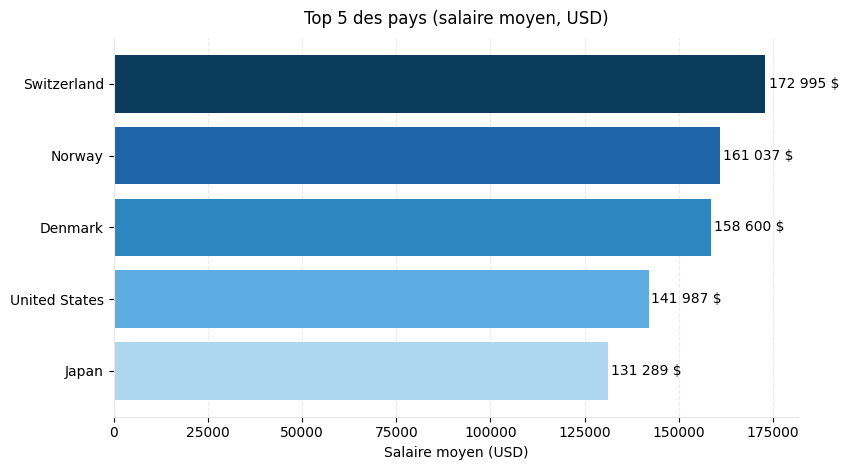

In [ ]:
###    7.3 TOP 5 DES PAYS (salaire moyen, USD)   ###

if 'df_clean' not in globals():
    raise ValueError("df_clean est introuvable.")
if 'company_location' not in df_clean.columns:
    raise ValueError("La colonne 'company_location' est absente de df_clean.")

base = df_clean[['company_location', 'salary_usd']].copy()
base['salary_usd'] = pd.to_numeric(base['salary_usd'], errors='coerce')
base = base.dropna(subset=['salary_usd'])
base = base[base['salary_usd'] > 0]

fmt_money = lambda v: f"{v:,.0f} $".replace(",", " ")
MIN_N = 80  # filtre de robustesse

g_country = (base.groupby('company_location')['salary_usd']
             .agg(mean='mean', count='count')
             .query('count >= @MIN_N')
             .sort_values('mean', ascending=False))

if g_country.empty:
    counts = base['company_location'].value_counts()
    raise ValueError(
        f"Aucun pays n'atteint MIN_N={MIN_N} offres. "
        f"Voici les 5 pays les plus fréquents:\n{counts.head(5)}"
    )

top_countries = g_country.head(5).copy()


colors_blue = ['#0B3C5D', '#1D65A6', '#2E86C1', '#5DADE2', '#AED6F1']
n = len(top_countries)
palette = colors_blue[:n][::-1]


fig, ax = plt.subplots(figsize=(8.6, 4.8))

# inverse l'index pour avoir le top en haut
bars = ax.barh(
    top_countries.index[::-1],
    top_countries['mean'][::-1],
    color=palette
)

# Labels à droite des barres  (salaire moyen formaté)
for bar, mean_val in zip(bars, top_countries['mean'][::-1]):
    ax.text(
        bar.get_width() * 1.005,
        bar.get_y() + bar.get_height() / 2,
        fmt_money(mean_val),
        va='center', fontsize=10
    )

ax.set_title("Top 5 des pays (salaire moyen, USD)", pad=10)
ax.set_xlabel("Salaire moyen (USD)")
ax.grid(axis='x', linestyle='--', alpha=0.25)
ax.set_axisbelow(True)

# Style des axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#e5e7eb')
ax.spines['bottom'].set_color('#e5e7eb')

plt.tight_layout()
plt.show()


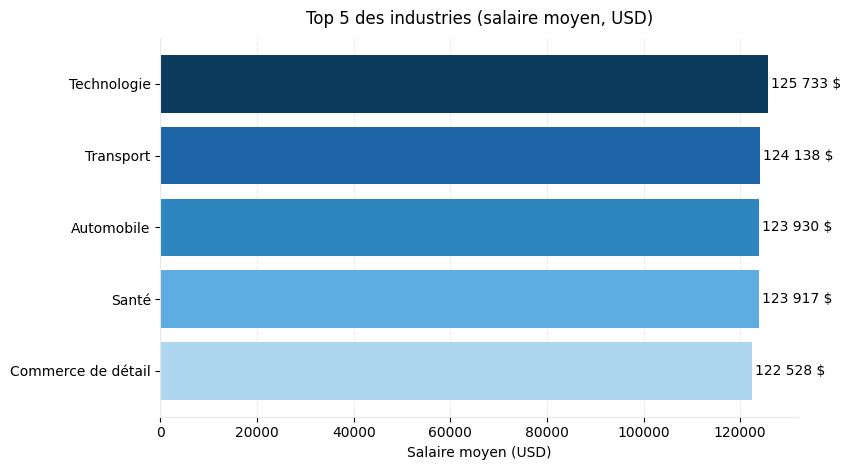

In [ ]:
###   7.4 TOP 5 SECTEURS (salaire moyen, USD)   ###

if 'df_clean' not in globals():
    raise ValueError("df_clean est introuvable.")
base = df_clean.copy()
base['salary_usd'] = pd.to_numeric(base['salary_usd'], errors='coerce')
base = base[(base['salary_usd'] > 0) & base['industry'].notna()]

# Traduction EN > FR
industry_fr = {
    'Technology': 'Technologie',
    'Healthcare': 'Santé',
    'Automotive': 'Automobile',
    'Transportation': 'Transport',
    'Retail': 'Commerce de détail',
}
base['industry_fr'] = base['industry'].map(industry_fr).fillna(base['industry'])

MIN_N = 80
agg = (base.groupby('industry_fr')['salary_usd']
       .agg(mean='mean', count='count')
       .query('count >= @MIN_N')
       .sort_values('mean', ascending=False))

top5 = agg.head(5).copy()

industries = top5.index
means      = top5['mean'].values

# Dégradé de bleu
colors_blue = ['#0B3C5D', '#1D65A6', '#2E86C1', '#5DADE2', '#AED6F1']
colors_blue = colors_blue[:len(top5)]
fmt_money = lambda v: f"{v:,.0f} $".replace(",", " ")



fig, ax = plt.subplots(figsize=(8.6, 4.8))

bars = ax.barh(industries, means, color=colors_blue, edgecolor='none')

ax.invert_yaxis()

for rect, val in zip(bars, means):
    ax.text(val * 1.005, rect.get_y() + rect.get_height()/2,
            fmt_money(val), va='center', fontsize=10)

ax.set_xlabel("Salaire moyen (USD)")
ax.set_title("Top 5 des industries (salaire moyen, USD)", pad=10)

ax.grid(axis='x', linestyle='--', alpha=0.25)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#e5e7eb')
ax.spines['bottom'].set_color('#e5e7eb')

plt.tight_layout()
plt.show()



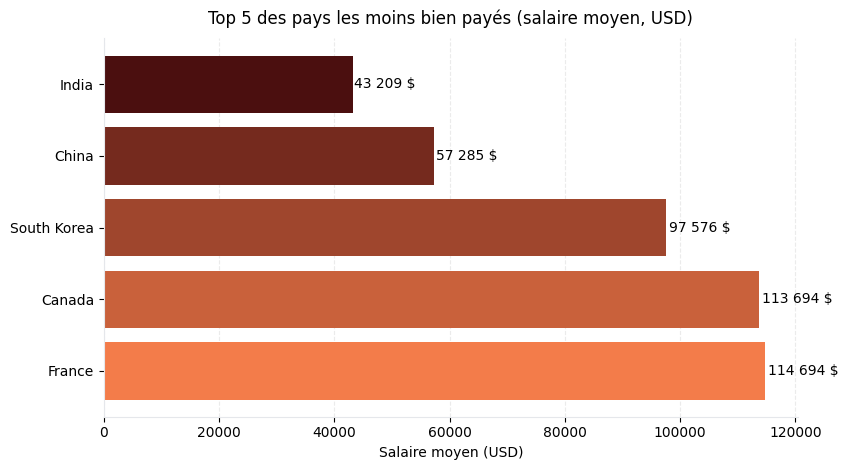

In [ ]:
###  7.5.  TOP 5 DES PAYS LES MOINS BIEN PAYEES (salaire moyen, USD)   ###


base = df_clean.copy()
base['salary_usd'] = pd.to_numeric(base['salary_usd'], errors='coerce')
base = base[base['salary_usd'] > 0]

fmt_money = lambda v: f"{v:,.0f} $".replace(",", " ")
MIN_N = 80

g_country = (
    base.groupby('company_location')['salary_usd']
        .agg(['mean', 'count'])
        .query('count >= @MIN_N')
        .sort_values('mean', ascending=True)
)

low_countries = g_country.head(5).copy()


cmap = LinearSegmentedColormap.from_list("bordeaux_orange", ['#4B0F0F', '#F37C4A'])
n = len(low_countries)
grad_colors = [cmap(t) for t in np.linspace(1.0, 0.0, n)]

labels = low_countries.index[::-1]
means  = low_countries['mean'][::-1]

fig, ax = plt.subplots(figsize=(8.6, 4.8))
bars = ax.barh(labels, means, color=grad_colors)

for bar, mean_val in zip(bars, means):
    ax.text(
        bar.get_width() * 1.005,
        bar.get_y() + bar.get_height()/2,
        f"{fmt_money(mean_val)}",
        va='center', fontsize=10
    )

ax.set_title("Top 5 des pays les moins bien payés (salaire moyen, USD)", pad=10)
ax.set_xlabel("Salaire moyen (USD)")
ax.grid(axis='x', linestyle='--', alpha=0.25)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#e5e7eb')
ax.spines['bottom'].set_color('#e5e7eb')

plt.tight_layout()
plt.show()

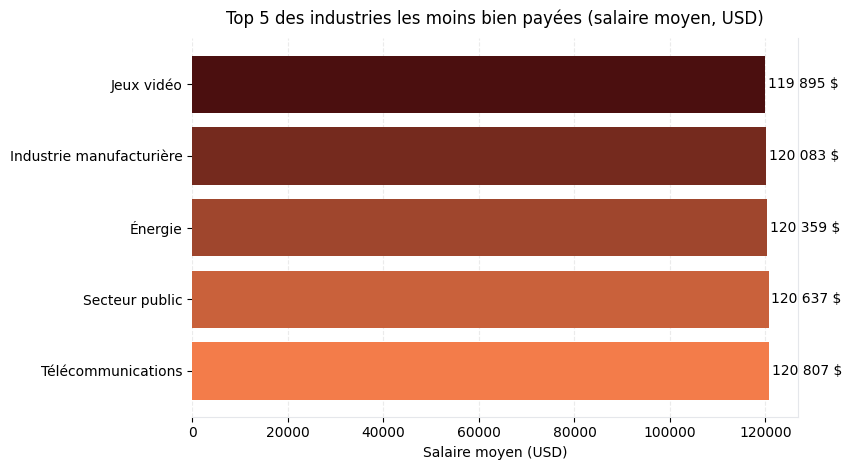

In [ ]:
### 7.6.  TOP 5 DES SECTEURS LES MOINS PAYÉS (salaire moyen, USD)  ###


if 'df_clean' not in globals():
    raise ValueError("df_clean est introuvable.")
base = df_clean.copy()
base['salary_usd'] = pd.to_numeric(base['salary_usd'], errors='coerce')
base = base[(base['salary_usd'] > 0) & base['industry'].notna()]

# --- Traduction FR pour les 5 secteurs demandés ---
industry_fr = {
    'gaming': 'Jeux vidéo',
    'manufacturing': 'Industrie manufacturière',
    'energy': 'Énergie',
    'government': 'Secteur public',
    'telecommunications': 'Télécommunications',
}
# on mappe en insensible à la casse pour ces 5, sinon on garde l’original
base['industry_fr'] = (
    base['industry'].astype(str)
        .apply(lambda x: industry_fr.get(x.strip().lower(), x))
)

MIN_N = 80
agg = (base.groupby('industry_fr')['salary_usd']
       .agg(mean='mean', count='count')
       .query('count >= @MIN_N')
       .sort_values('mean', ascending=True))
low5 = agg.head(5).copy()

# Dégradé bordeaux -> orange
cmap = LinearSegmentedColormap.from_list("bordeaux_orange", ['#4B0F0F', '#F37C4A'])
n = len(low5)
grad_colors = [cmap(t) for t in np.linspace(1.0, 0.0, n)]

labels = low5.index[::-1]
means  = low5['mean'][::-1].values

fmt_money = lambda v: f"{v:,.0f} $".replace(",", " ")

fig, ax = plt.subplots(figsize=(8.6, 4.8))

bars = ax.barh(labels, means, color=grad_colors, edgecolor='none')

for rect, val in zip(bars, means):
    ax.text(val * 1.005, rect.get_y() + rect.get_height()/2,
            fmt_money(val), va='center', fontsize=10)

ax.set_title("Top 5 des industries les moins bien payées (salaire moyen, USD)", pad=10)
ax.set_xlabel("Salaire moyen (USD)")
ax.grid(axis='x', linestyle='--', alpha=0.25)
ax.set_axisbelow(True)

# Finitions
ax.spines['top'].set_visible(False)
ax.spines['right'].set_color('#e5e7eb')
ax.spines['bottom'].set_color('#e5e7eb')
ax.spines['left'].set_visible(False)


plt.tight_layout()
plt.show()



In [ ]:
###   8. CARTES BULLES SALAIRES/PAYSC  ###


if 'df_clean' not in globals():
    raise ValueError("df_clean est introuvable.")

df_geo = df_clean.copy()
df_geo['salary_usd'] = pd.to_numeric(df_geo['salary_usd'], errors='coerce')
df_geo = df_geo.dropna(subset=['salary_usd', 'company_location'])
df_geo = df_geo[df_geo['salary_usd'] > 0]

# Harmonisation minimale de quelques noms de pays (si nécessaire)
country_fix = {
    'United States of America': 'United States',
    'USA': 'United States',
    'UK': 'United Kingdom',
    'UAE': 'United Arab Emirates',
    'Korea, South': 'South Korea',
    'Republic of Korea': 'South Korea',
}
df_geo['company_location'] = df_geo['company_location'].replace(country_fix)

#  Agrégats par pays : moyenne & volume ---
agg2 = (df_geo.groupby('company_location')['salary_usd']
        .agg(salary_mean_usd='mean', n_offres='count')
        .reset_index())

# Sécurisation si aucun pays
if agg2.empty:
    raise ValueError("Pas de données valides pour construire la carte (vérifie salary_usd/company_location).")

#  Carte bulles : taille = n_offres, couleur = salaire moyen ---
fig = px.scatter_geo(
    agg2,
    locations='company_location',
    locationmode='country names',
    size='n_offres',
    size_max=40,
    color='salary_mean_usd',
    color_continuous_scale=['#F37C4A', '#C84017', '#7F1D1D', '#4B0F0F'],  # orange → bordeaux
    hover_name='company_location',
    hover_data={'salary_mean_usd': ':.0f', 'n_offres': True},
    title='Offres (taille) & salaire moyen (couleur) par pays'
)

fig.update_layout(
    coloraxis_colorbar=dict(title='Salaire moyen (USD)'),
    margin=dict(l=10, r=10, t=60, b=10)
)
fig.update_traces(
    hovertemplate="<b>%{hovertext}</b><br>Salaire moyen: %{customdata[0]:,.0f} $<br>Offres: %{customdata[1]:,}"
)

fig.show()


Top 20 pays par nombre d'offres :
       country  n_offres
   Switzerland       819
        Canada       781
United Kingdom       780
 United States       776
     Singapore       762
         China       760
       Denmark       759
        Israel       758
       Ireland       757
   South Korea       755
        France       749
   Netherlands       748
       Germany       746
         Japan       742
        Norway       739
        Sweden       729
     Australia       721
       Finland       718
         India       702
       Austria       699


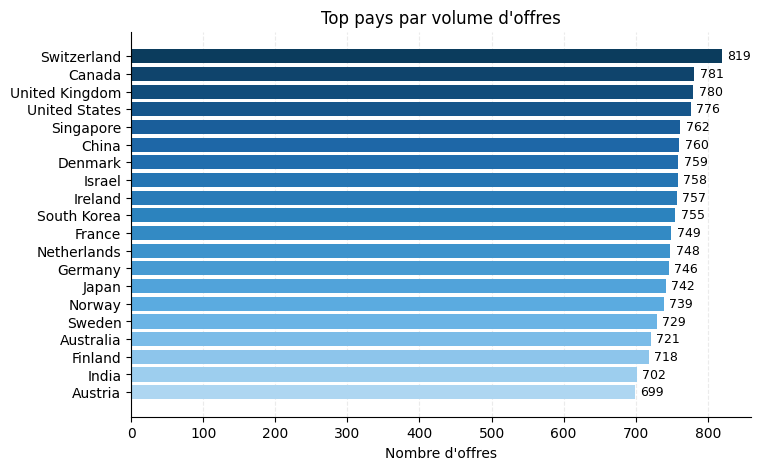

In [ ]:
###  9. PAYS AVEC LE PLUS D'OFFRES  ###


if 'df_clean' not in globals():
    raise ValueError("df_clean est introuvable.")

# Copie de travail
d = df_clean.copy()

# Nettoyage minimal
d = d.dropna(subset=['company_location'])
d['company_location'] = d['company_location'].astype(str).str.strip()

# Harmonisation des noms (cohérence avec les autres cartes)
country_fix = {
    'United States of America': 'United States',
    'USA': 'United States',
    'US': 'United States',
    'UK': 'United Kingdom',
    'UAE': 'United Arab Emirates',
    'Korea, South': 'South Korea',
    'Republic of Korea': 'South Korea',
}
d['company_location'] = d['company_location'].replace(country_fix)

# Dé-duplication éventuelle
if 'job_id' in d.columns:
    d = d.drop_duplicates(subset=['job_id'])

# Comptage
country_counts = (
    d['company_location']
      .value_counts()
      .rename_axis('country')
      .reset_index(name='n_offres')
)

# Top 20
top20 = country_counts.head(20)
print("Top 20 pays par nombre d'offres :")
print(top20.to_string(index=False))

# — Dégradé bleu foncé -> bleu clair —
cmap = LinearSegmentedColormap.from_list("dark_to_light_blue", ['#0B3C5D', '#1D65A6', '#2E86C1', '#5DADE2', '#AED6F1'])
n = len(top20)
# On génère n couleurs et on inverse pour que la plus foncée soit en haut (après inversion des barres)
grad_colors = [cmap(t) for t in np.linspace(1.0, 0.0, n)]

# — Visualisation —
fig, ax = plt.subplots(figsize=(8, 5))

# Inversion pour avoir le pays le plus volumineux en haut
labels = top20['country'][::-1]
values = top20['n_offres'][::-1]

bars = ax.barh(labels, values, color=grad_colors, edgecolor='none')

# Étiquettes numériques
for b, v in zip(bars, values):
    ax.text(v * 1.01, b.get_y() + b.get_height()/2, f"{v:,}".replace(",", " "), va='center', fontsize=9)

ax.set_title("Top pays par volume d'offres")
ax.set_xlabel("Nombre d'offres")
ax.grid(axis='x', linestyle='--', alpha=0.25)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)


Top 5 compétences techniques (part des offres) :
            count  percentage
skill                        
python       4499        30.0
sql          3511        23.4
tensorflow   3096        20.6
kubernetes   3078        20.5
pytorch      2831        18.9


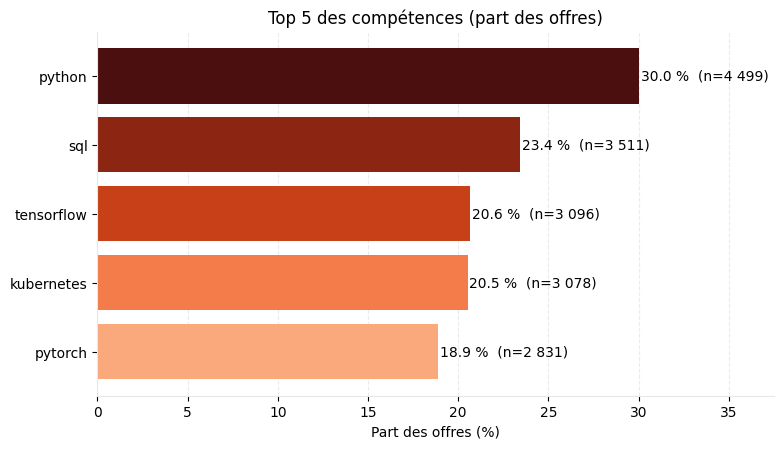

In [ ]:
###   10.   TOP 5 DES COMPETENCES TECHNIQUES    ###



df_src = None
for name in ['df_clean', 'df_processed']:
    if name in globals():
        df_src = globals()[name].copy()
        break
if df_src is None:
    raise ValueError("Aucun DataFrame dispo.")

if 'required_skills' not in df_src.columns:
    raise ValueError("Colonne 'required_skills' absente du DataFrame.")

if 'job_id' in df_src.columns:
    df_src = df_src.drop_duplicates(subset=['job_id'])

skills = (
    df_src['required_skills']
      .fillna('')
      .astype(str)
      .str.replace(r'\s+', ' ', regex=True)
)


tmp = (
    skills.str.split(',')
          .explode()
          .str.strip()
          .str.lower()
)

tmp = tmp[tmp != '']

# Compter une compétence au plus 1 fois par offre
#     reconstitue un index offre + skill pour éviter les doublons intra-offre
if 'job_id' in df_src.columns:
    # joindre l'id d’offre avant explode
    pairs = (df_src[['job_id']].join(tmp.rename('skill'))).dropna(subset=['skill'])
    pairs = pairs.drop_duplicates(subset=['job_id', 'skill'])
    counts = pairs['skill'].value_counts()
    total_offers = len(df_src)
else:
    # fallback : pas de job_id -> on compte les occurrences (proche du nb d'offres si pas de doublons intra-offre)
    counts = tmp.value_counts()
    total_offers = len(df_src)

skill_counts_df = (
    counts.rename('count')
          .to_frame()
          .assign(percentage=lambda d: d['count'] / total_offers * 100)
          .sort_values('count', ascending=False)
)

top5 = skill_counts_df.head(5).copy()

print("Top 5 compétences techniques (part des offres) :")
print(
    top5.assign(percentage=lambda d: d['percentage'].round(1))
        .to_string()
)


palette = ['#4B0F0F', '#8C2613', '#C84017', '#F37C4A', '#F9A97B']
skills_order = top5.index[::-1]
vals = top5.loc[skills_order, 'percentage'].values

fig, ax = plt.subplots(figsize=(8, 4.6))
bars = ax.barh(skills_order, vals, color=palette[::-1], edgecolor='none')


for b, perc, skill in zip(bars, vals, skills_order):
    n = int(top5.loc[skill, 'count'])
    label = f"{perc:.1f} %  (n={n:,})".replace(",", " ")
    ax.text(b.get_width() * 1.005, b.get_y() + b.get_height()/2,
            label, va='center', fontsize=10)

ax.set_title("Top 5 des compétences (part des offres)")
ax.set_xlabel("Part des offres (%)")
ax.set_xlim(0, max(vals)*1.25)


ax.grid(axis='x', linestyle='--', alpha=0.25)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#e5e7eb'); ax.spines['bottom'].set_color('#e5e7eb')

plt.tight_layout()
plt.show()


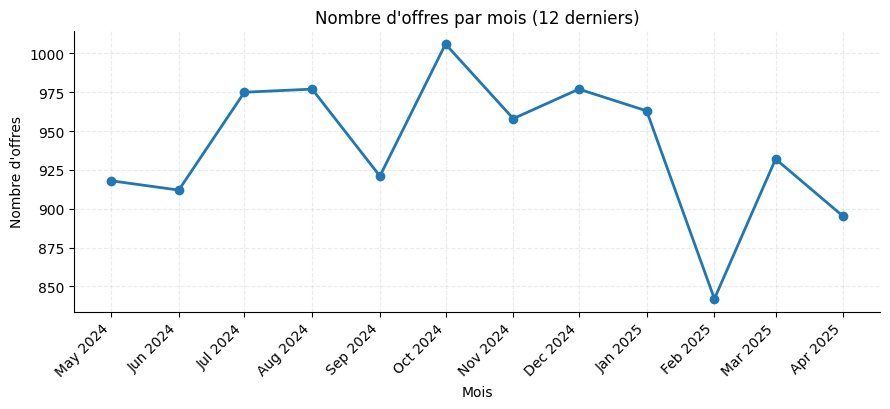

In [ ]:
###   11.  OFFRES PAR MOIS    ###

if 'df_clean' not in globals():
    raise ValueError("df_clean est introuvable.")

d = df_clean.copy()
if 'posting_date' not in d.columns:
    raise ValueError("Colonne 'posting_date' absente.")


d['posting_date'] = pd.to_datetime(d['posting_date'], errors='coerce')
d = d.dropna(subset=['posting_date'])


if 'job_id' in d.columns:
    d = d.drop_duplicates(subset=['job_id'])


d['month'] = d['posting_date'].dt.to_period('M').dt.to_timestamp()


ts = d.groupby('month').size().rename('offres').sort_index()


if not ts.empty:
    end = ts.index.max()
    start = (end - pd.DateOffset(months=11)).replace(day=1)  # fenêtre de 12 mois
    full_idx = pd.date_range(start=start, end=end, freq='MS')
    ts_12 = ts.reindex(full_idx, fill_value=0)
else:
    ts_12 = pd.Series(dtype=int)

# Plot
fig, ax = plt.subplots(figsize=(9, 4.2))
ax.plot(ts_12.index, ts_12.values, marker='o', linewidth=2)

ax.set_title("Nombre d'offres par mois (12 derniers)")
ax.set_xlabel("Mois")
ax.set_ylabel("Nombre d'offres")
ax.grid(True, linestyle='--', alpha=0.25)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ticks lisibles (1 label sur 2 si besoin)
if len(ts_12) > 0:
    labels = [d.strftime('%b %Y') for d in ts_12.index]
    ax.set_xticks(ts_12.index)
    ax.set_xticklabels(labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

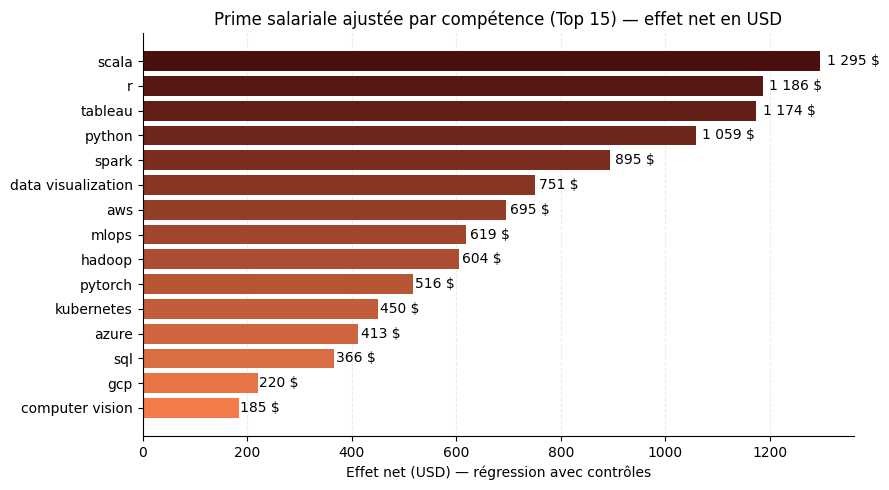


Top 10 — Compétences les plus présentes (Pareto) :
- python             : 30.0 % des offres (cumul 30.0 %)
- sql                : 23.3 % des offres (cumul 53.4 %)
- tensorflow         : 20.6 % des offres (cumul 74.0 %)
- kubernetes         : 20.6 % des offres (cumul 94.6 %)
- pytorch            : 18.9 % des offres (cumul 113.5 %)
- scala              : 18.4 % des offres (cumul 131.8 %)
- linux              : 17.6 % des offres (cumul 149.5 %)
- java               : 16.9 % des offres (cumul 166.4 %)
- git                : 16.6 % des offres (cumul 183.0 %)
- gcp                : 16.4 % des offres (cumul 199.4 %)

Top 10 — Prime ajustée (régression) :
- scala              : +1 295 $ (n_with=2 698)
- r                  : +1 186 $ (n_with=2 302)
- tableau            : +1 174 $ (n_with=2 267)
- python             : +1 059 $ (n_with=4 414)
- spark              : +895 $ (n_with=2 229)
- data visualization : +751 $ (n_with=2 235)
- aws                : +695 $ (n_with=2 078)
- mlops             

In [ ]:
###   Prime salariale ajustée (régression linéaire)   ### (Juste pour voir mais pas inclu dans la presentation)  ###



if 'df_clean' not in globals():
    raise ValueError("df_clean est introuvable.")

d = df_clean.copy()
d['salary_usd'] = pd.to_numeric(d['salary_usd'], errors='coerce')
d = d[(d['salary_usd'] > 0) & d['required_skills'].notna()]

# (Option anti-outliers pour la régression : tronquer P1–P99)
p1, p99 = np.nanpercentile(d['salary_usd'], [1, 99])
d = d[(d['salary_usd'] >= p1) & (d['salary_usd'] <= p99)].copy()


# Extraction des skills + Top-N par fréquence

skills_series = (
    d['required_skills'].str.lower()
                        .str.replace(r'\s+', ' ', regex=True)
                        .str.split(',')
)

exploded = skills_series.explode().str.strip()
exploded = exploded[exploded != '']

counts = exploded.value_counts()
TOTAL_OFFRES = len(d)
TOP_N = 20

top_counts = counts.head(TOP_N).to_frame('count')
top_counts['%_offres'] = (top_counts['count'] / TOTAL_OFFRES * 100)
top_counts['%_cumul']  = top_counts['%_offres'].cumsum()


# Matrice binaire des skills Top-N (pour régression)

# Liste de skills propres par ligne
d['_skills_list'] = skills_series.apply(lambda L: [str(s).strip().lower() for s in (L or []) if str(s).strip() != ''])
top_skills = top_counts.index.tolist()

for sk in top_skills:
    d[f'skill__{sk}'] = d['_skills_list'].apply(lambda L, s=sk: s in L).astype(int)


# Régression linéaire (effet net par skill) avec contrôles

controls_cat = [c for c in [
    'experience_level','employment_type','company_location','company_size','remote_status'
] if c in d.columns]

controls_num = [c for c in [
    'years_experience','benefits_score','job_description_length'
] if c in d.columns]

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

X_cat = ohe.fit_transform(d[controls_cat]) if controls_cat else csr_matrix((len(d), 0))
X_num = csr_matrix(d[controls_num].to_numpy()) if controls_num else csr_matrix((len(d), 0))

skill_cols = [f"skill__{sk}" for sk in top_skills]
X_skills = csr_matrix(d[skill_cols].to_numpy()) if skill_cols else csr_matrix((len(d), 0))

X = hstack([X_cat, X_num, X_skills], format='csr')
y = d['salary_usd'].to_numpy()

lr = LinearRegression()
lr.fit(X, y)

# Coefficients des skills (USD, effet net)
coefs = pd.Series(lr.coef_, index=(list(ohe.get_feature_names_out(controls_cat)) if controls_cat else []) + controls_num + skill_cols)
skill_effects = (coefs[skill_cols]
                 .rename(lambda s: s.replace('skill__',''))
                 .to_frame('coef_usd')
                 .reset_index().rename(columns={'index':'skill'}))

# Effectif "avec la skill"
n_with = {sk: int(d[f"skill__{sk}"].sum()) for sk in top_skills}
skill_effects['n_with'] = skill_effects['skill'].map(n_with)

# Top 15 effets positifs
top_effects = skill_effects.sort_values('coef_usd', ascending=False).head(15)

fmt_money = lambda v: f"{v:,.0f} $".replace(",", " ")

# GRAPHE Prime salariale ajustée (effet net, USD)


palette = ['#4B0F0F', '#8C2613', '#C84017', '#F37C4A', '#F9A97B']
if len(top_effects) > len(palette):
    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list("bordeaux_orange", ['#4B0F0F', '#F37C4A'])
    colors = [cmap(t) for t in np.linspace(0.0, 1.0, len(top_effects))]
else:
    colors = palette[:len(top_effects)]

fig, ax = plt.subplots(figsize=(9, 5))
skills = top_effects['skill'].values[::-1]
vals   = top_effects['coef_usd'].values[::-1]

ax.barh(skills, vals, color=colors[::-1], edgecolor='none')
for y0, v in enumerate(vals):
    ax.text(v * 1.01, y0, fmt_money(v), va='center', fontsize=10)

ax.set_title("Prime salariale ajustée par compétence (Top 15) — effet net en USD")
ax.set_xlabel("Effet net (USD) — régression avec contrôles")
ax.grid(axis='x', linestyle='--', alpha=0.25)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


# Résumé

print("\nTop 10 — Compétences les plus présentes (Pareto) :")
for sk, row in top_counts.head(10).iterrows():
    print(f"- {sk:<18s} : {row['%_offres']:.1f} % des offres (cumul {row['%_cumul']:.1f} %)")

print("\nTop 10 — Prime ajustée (régression) :")
for _, r in top_effects.head(10).iterrows():
    print(f"- {r['skill']:<18s} : +{fmt_money(r['coef_usd'])} (n_with={r['n_with']:,})".replace(",", " "))


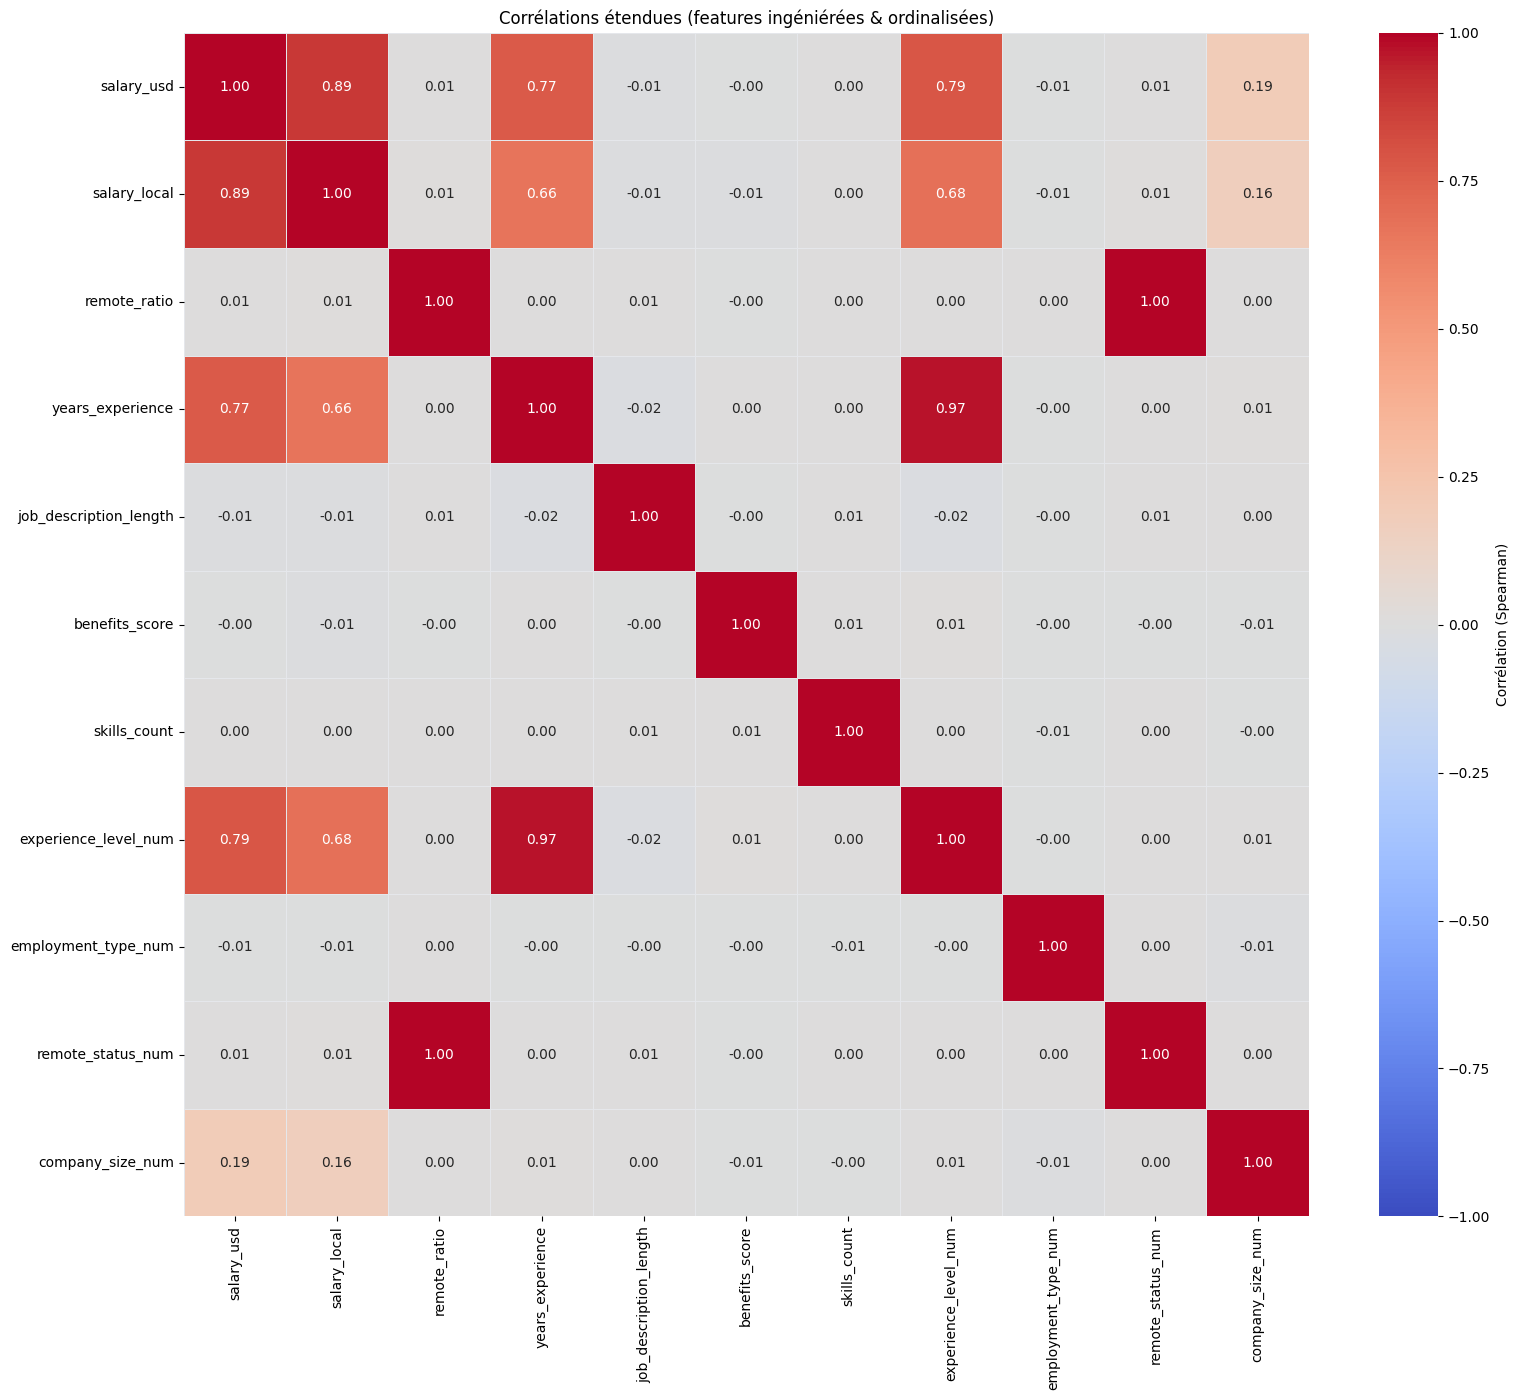

In [ ]:
###  12.  MATRICE DE CORRELATION   ###  ( Pas inclue non-plus dans la presentation)

if 'df_clean' not in globals():
    raise ValueError("df_clean est introuvable.")

X = df_clean.copy()

# ---------- Features ingéniérées  ----------
# Longueur de description
if 'job_description' in X.columns:
    X['job_description_length'] = X['job_description'].astype(str).str.len()

# Nombre de compétences
if 'required_skills' in X.columns:
    X['skills_count'] = (
        X['required_skills'].fillna('')
        .astype(str)
        .str.split(',')
        .apply(lambda lst: 0 if lst == [''] else len(lst))
    )

# Ordinalisation du niveau d'expérience
if 'experience_level' in X.columns:
    exp_map = {
        'EN':'Entry-level','Entry':'Entry-level','Junior':'Entry-level','Entry-level':'Entry-level',
        'MI':'Mid-level','Mid':'Mid-level','Mid-level':'Mid-level',
        'SE':'Senior-level','Senior':'Senior-level','Senior-level':'Senior-level',
        'EX':'Executive-level','Expert':'Executive-level','Executive-level':'Executive-level'
    }
    X['experience_level_norm'] = (
        X['experience_level'].replace(exp_map).astype(str).str.strip()
    )
    exp_ord = {'Entry-level':1, 'Mid-level':2, 'Senior-level':3, 'Executive-level':4}
    X['experience_level_num'] = X['experience_level_norm'].map(exp_ord)

# Ordinalisation du type de contrat
if 'employment_type' in X.columns:
    emp_map = {
        'FT':'Full-time','PT':'Part-time','CT':'Contract','FL':'Freelance',
        'Full-time':'Full-time','Part-time':'Part-time','Contract':'Contract','Freelance':'Freelance'
    }
    X['employment_type_norm'] = (
        X['employment_type'].replace(emp_map).astype(str).str.strip()
    )
    # Ordre indicatif : Part-time < Freelance/Contract < Full-time
    emp_ord = {'Part-time':1, 'Freelance':2, 'Contract':2, 'Full-time':3}
    X['employment_type_num'] = X['employment_type_norm'].map(emp_ord)

# Remote : ratio numérique + statut ordinal
if 'remote_ratio' in X.columns:
    X['remote_ratio'] = pd.to_numeric(X['remote_ratio'], errors='coerce')
    # Statut basé sur remote_ratio si remote_status absent
    if 'remote_status' not in X.columns:
        rr = X['remote_ratio']
        X['remote_status'] = np.select(
            [rr.eq(100), rr.eq(50), rr.eq(0)],
            ['Full Remote','Partial Remote','On-site'],
            default=np.nan
        )
if 'remote_status' in X.columns:
    rem_ord = {'On-site':0, 'Partial Remote':50, 'Full Remote':100}
    X['remote_status_num'] = X['remote_status'].map(rem_ord)

# Taille d’entreprise (plusieurs formats gérés)
if 'company_size' in X.columns:
    cs = X['company_size'].astype(str).str.strip()
    # Map pour S/M/L
    size_map_basic = {'S':1, 'M':2, 'L':3, 'Small':1, 'Medium':2, 'Large':3}
    # Pour des classes de type "1-50", "51-100", etc. => on prend la borne sup comme proxy
    def _size_to_num(v):
        if v in size_map_basic:
            return size_map_basic[v]
        if '-' in v:
            try:
                hi = int(v.split('-')[-1])
                if hi <= 50: return 1
                if hi <= 250: return 2
                return 3
            except:
                return np.nan
        return np.nan
    X['company_size_num'] = cs.map(_size_to_num)


for col in ['years_experience', 'benefits_score', 'job_description_length', 'skills_count',
            'experience_level_num', 'employment_type_num', 'remote_status_num', 'company_size_num',
            'remote_ratio', 'salary_usd']:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Sélection des colonnes candidates
# On garde salary_usd + toutes les colonnes numériques présentes
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
if 'salary_usd' not in num_cols:
    raise ValueError("'salary_usd' n'est pas numérique ou absent après nettoyage.")

# Facultatif : ignorer les colonnes quasi constantes (variance ~ 0)
def _has_variance(s):
    s_ = s.dropna()
    return s_.nunique() > 1

candidates = [c for c in num_cols if _has_variance(X[c])]
# Exclure les ID techniques s'il y en a
for junk in ['job_id', 'company_id', 'posting_year']:  # adapte si nécessaire
    if junk in candidates:
        candidates.remove(junk)

d = X[candidates].copy()

#  Corrélation (Spearman)
corr = d.corr(method='spearman')

# Option lisibilité : garder les Top k variables les plus corrélées au salaire
TOP_K = 12
if corr.shape[0] > TOP_K:
    # Scores d'importance absolue > salary_usd
    target = 'salary_usd'
    if target in corr.columns:
        order = (corr[target].abs().sort_values(ascending=False)
                 .head(TOP_K).index.tolist())
        # Inclure aussi le target si pas présent
        if target not in order:
            order = [target] + [c for c in order if c != target]
        corr = corr.loc[order, order]

plt.figure(figsize=(1.1 * corr.shape[0] + 4, 1.1 * corr.shape[0] + 2))
sns.heatmap(
    corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1,
    linewidths=0.5, linecolor="#e5e7eb",
    cbar_kws={'label':'Corrélation (Spearman)'}
)
plt.title("Corrélations étendues (features ingéniérées & ordinalisées)")
plt.tight_layout()
plt.show()

=== Performance test ===
R²   : 0.8884
RMSE : 21 149 $
MAE  : 15 325 $


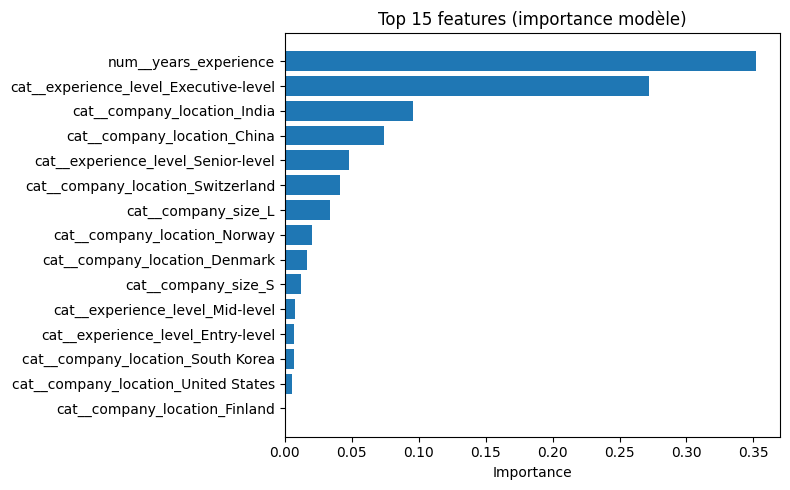

In [ ]:
###   13.   MACHINE LEARNING (GBM)    ###

#  Modélisation salaires


if 'df_clean' not in globals():
    raise ValueError("df_clean est introuvable.")

data = df_clean.copy()

# 1) Cible + filtre de sécurité
target = 'salary_usd'
if target not in data.columns:
    raise ValueError(f"Colonne cible '{target}' absente.")

data[target] = pd.to_numeric(data[target], errors='coerce')
data = data.dropna(subset=[target])
data = data[data[target] > 0]

# 2) Sélection des features (baseline)
drop_cols = [
    'job_id', 'salary_currency', 'salary_local',
    'posting_date', 'application_deadline', 'company_name'
]
X = data.drop(columns=[c for c in drop_cols if c in data.columns] + [target])
y = data[target].astype(float)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# 3) Préprocesseurs
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Compat min_frequency/sparse_output selon version
try:
    cat_ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=0.01, sparse_output=True)
except TypeError:
    cat_ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", cat_ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

# 4) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 5) Modèle
model = GradientBoostingRegressor(random_state=42)

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", model)
])

# 6) Entraînement
pipe.fit(X_train, y_train)

# 7) Évaluation (RMSE sans 'squared' pour compat)
y_pred = pipe.predict(X_test)
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("=== Performance test ===")
print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:,.0f} $".replace(",", " "))
print(f"MAE  : {mae:,.0f} $".replace(",", " "))

# 8) (Option) Top features si possible
try:
    preprocessor.fit(X_train)
    feat_names = preprocessor.get_feature_names_out()
    gb = pipe.named_steps["model"]
    if hasattr(gb, "feature_importances_"):
        importances = gb.feature_importances_
        top_idx = np.argsort(importances)[::-1][:15]
        labels = [feat_names[i] for i in top_idx][::-1]
        vals   = [importances[i] for i in top_idx][::-1]

        plt.figure(figsize=(8, 5))
        plt.barh(labels, vals)
        plt.title("Top 15 features (importance modèle)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"(Note) Importances non affichées : {e}")



In [ ]:
###  13.2.    Train vs Test     ###

y_pred_tr = pipe.predict(X_train)
y_pred_te = pipe.predict(X_test)

r2_tr   = r2_score(y_train, y_pred_tr)
rmse_tr = np.sqrt(mean_squared_error(y_train, y_pred_tr))
mae_tr  = mean_absolute_error(y_train, y_pred_tr)

r2_te   = r2_score(y_test, y_pred_te)
rmse_te = np.sqrt(mean_squared_error(y_test, y_pred_te))
mae_te  = mean_absolute_error(y_test, y_pred_te)

print("Train  -> R²={:.3f}  RMSE={:,.0f}  MAE={:,.0f}".format(r2_tr, rmse_tr, mae_tr).replace(","," "))
print("Test   -> R²={:.3f}  RMSE={:,.0f}  MAE={:,.0f}".format(r2_te, rmse_te, mae_te).replace(","," "))


Train  -> R²=0.889  RMSE=21 384  MAE=15 363
Test   -> R²=0.888  RMSE=21 149  MAE=15 325


Resultat Train comparé à Test montre qu'il n'y a pas d'overfiting.
